In [1]:
library(CausalImpact)
library(matrixStats)

Loading required package: bsts
Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts


In [2]:
data <- read.csv(file = 'CausalImpact_homework_data1.csv', header = TRUE, sep = ',')

In [3]:
head(data)

date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
2013-12-18,21110.60,5855898,10490066,6400020,17303909,8277376,202418.0,501304.0,281527.7,⋯,2.46,20.30,11.76,13.53,27.36,23.53,41.25,NA,23.73,9.24
2013-12-19,19985.20,5233946,8856544,5772768,13711773,7417712,195205.4,456269.5,222715.5,⋯,2.05,13.05,12.25,14.76,28.50,28.96,37.95,11.94,31.64,6.93
2013-12-20,19602.36,4923801,8346250,5429014,12574661,6999351,205468.9,496172.0,283458.8,⋯,1.23,23.20,10.78,9.84,45.03,27.15,34.65,7.96,28.25,3.85
2013-12-21,21955.16,6061035,10408902,6624329,17318726,8561364,210051.0,516636.4,272849.0,⋯,3.28,24.65,10.78,11.07,44.46,25.34,36.30,5.97,38.42,8.47
2013-12-22,22388.32,6139137,10323537,6646342,16883212,8662216,217223.1,530008.4,269956.1,⋯,1.23,31.90,12.74,11.07,53.01,23.53,49.50,3.98,39.55,5.39
2013-12-23,23793.20,6368549,10494566,6864796,17262817,8962794,209871.1,536184.1,308934.5,⋯,1.64,26.10,6.86,8.61,51.87,18.10,46.20,3.98,35.03,12.32


In [4]:
intervention <- read.csv(file = 'CausalImpact_homework_data2.csv', header = TRUE, sep = ',')

In [5]:
head(intervention)

num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
1,26,56,4.6,1
2,31,60,0.1,0
3,52,66,0.5,1
4,111,144,5.7,1
5,174,197,2.6,0
6,200,212,10.0,0


Видим в intervention много нерелевантных по времени кампаний. Чтобы их отсеять, найдем, какие номера соответствуют началу и концу анализируемого периода:

In [6]:
num_start <- which(as.Date(data$date) >= as.Date("2015-08-01"))[1]
num_end <- which(as.Date(data$date) >= as.Date("2015-12-01"))[1] - 1

In [7]:
intervention <- intervention[intervention$end_date >= num_start & intervention$start_date <= num_end, ]

В data данные после ноября 2015 нам тоже не нужны. До августа 2015 нужны, так как на них будем обучаться:

In [8]:
data <- data[1:num_end, ]

Посмотрим, что осталось в intervention:

In [9]:
intervention

,num,start_date,end_date,estimation_size_of_marketing_activity,is_related_to_our_service
22,22,560,599,4.9,0
25,25,623,637,1.5,1
26,26,623,668,0.1,1
27,27,630,668,0.0,0
28,28,633,644,0.7,0
29,29,651,667,0.4,0
30,30,690,720,0.2,1
31,31,694,707,0.0,1
32,32,697,730,0.1,0
33,33,708,725,1.5,1


Первая кампания не нужна, так как она не относится к нашему сервису и не влият на относящиеся кампании, потому что не пересекается с ними по времени. Уберем ее:

In [10]:
intervention <- intervention[2:nrow(intervention), ]

Посмотрим теперь, как выглядит target:

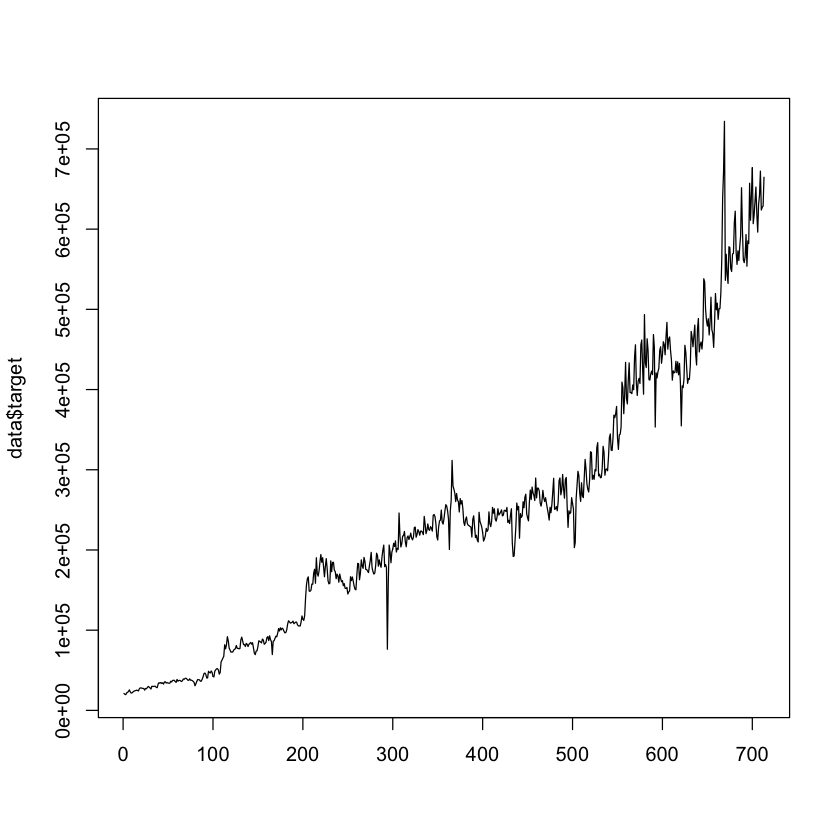

In [11]:
matplot(data$target, type = "l")

Ряд явно начинает вести себя как-то по-другому с 200 точки, а перед 300, кажется, выброс. Давайте избавимся от этого:

In [12]:
data <- data[450:nrow(data), ]

In [13]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
450,2015-03-12,239985.6,12080657,19043853,9748179,42823118,16954069,807599.1,1293694,247801.5,⋯,27.06,626.40,431.20,60.27,473.67,181.00,740.85,73.63,874.62,87.01
451,2015-03-13,236268.0,11458288,17888061,9203161,42878567,16092148,792762.6,1251900,225759.3,⋯,22.55,640.90,419.93,73.80,489.06,226.25,730.95,73.63,988.75,86.24
452,2015-03-14,259683.2,14493612,21579765,11418753,42934016,20255595,897144.7,1462741,289986.5,⋯,30.75,706.15,359.17,50.43,487.35,244.35,711.15,75.62,1143.56,73.92
453,2015-03-15,274737.0,14826659,21880725,11697160,42989465,20746630,886230.1,1475938,300821.4,⋯,25.42,707.60,456.19,88.56,492.48,175.57,759.00,73.63,1093.84,105.49
454,2015-03-16,262901.6,14392917,21755270,11488617,43044915,20134447,899885.9,1501280,299208.6,⋯,22.96,653.95,427.28,68.88,461.13,166.52,699.60,67.66,974.06,79.31
455,2015-03-17,278436.2,15346139,22094107,11838508,43100364,21440868,898894.2,1483711,293789.2,⋯,19.27,614.80,441.00,67.65,438.90,179.19,674.85,59.70,937.90,78.54


Итого, убрали все до 12 марта 2015. Данных для обучения все еще хватает -- почти пять месяцев до начала августа.

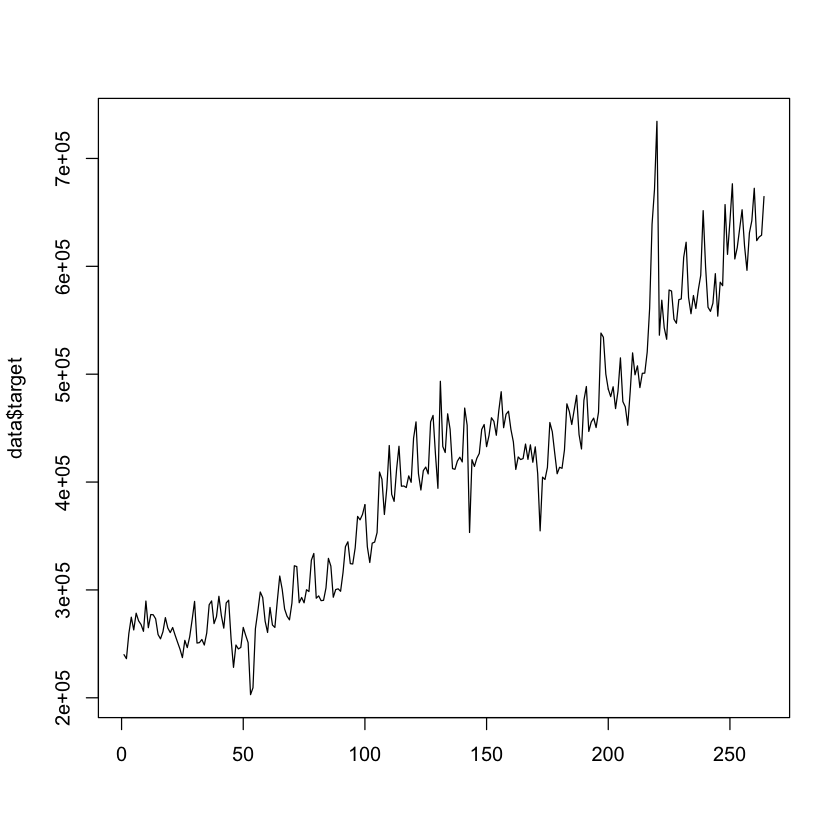

In [14]:
matplot(data$target, type = "l")

Ряд уже выглядит получше. Теперь уже можно начать искать ряды-предикторы, по которым будем предсказывать таргет.

Чтобы было удобно сравнивать похожесть рядов, давайте их отмасштабируем. Для этого еще удалим все N/A. Благо, таких строк в нужных данных, меньше 2%:

In [22]:
sum(complete.cases(data)) / nrow(data)

[1] 0.9810606

In [23]:
data <- data[complete.cases(data), ]

Отнимаем минимумы по колонкам:

In [44]:
data_wo_date <- data[2:ncol(data)]
col_mins <- colMins(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date - matrix(col_mins, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

Делим на максимумы:

In [48]:
data_wo_date <- data[2:ncol(data)]
col_maxs <- colMaxs(as.matrix(data_wo_date))
data[2:ncol(data)] <- data_wo_date / matrix(col_maxs, nrow = nrow(data), ncol = ncol(data) - 1, byrow = TRUE)

In [50]:
head(data)

,date,target,market_1,market_2,market_3,market_4,market_5,should_be_impacted_1,should_be_impacted_2,should_be_impacted_3,⋯,may_be_not_impacted_3,may_be_not_impacted_4,may_be_not_impacted_5,may_be_not_impacted_6,may_be_not_impacted_7,may_be_not_impacted_8,may_be_not_impacted_9,may_be_not_impacted_10,may_be_not_impacted_11,may_be_not_impacted_12
450,2015-03-12,0.06977298,0.1253389,0.2025482,0.3830860,0.000000000,0.12478597,0.07203693,0.02644608,0.09063743,⋯,0.026567481,0.09473684,0.11602527,0.06896552,0.06390182,0.06896552,0.019917800,0.04435484,0.006457167,0.071161049
451,2015-03-13,0.06277866,0.0995555,0.1536997,0.3541401,0.003802281,0.09912724,0.05103831,0.00000000,0.04668978,⋯,0.014877790,0.10977444,0.10281447,0.14482759,0.07532797,0.12643678,0.018020866,0.04435484,0.049935428,0.067415730
452,2015-03-14,0.10683247,0.2253023,0.3097262,0.4718101,0.007604562,0.22306973,0.19877419,0.13341473,0.17474596,⋯,0.036131775,0.17744361,0.03159104,0.01379310,0.07405840,0.14942529,0.014227000,0.04838710,0.108910891,0.007490637
453,2015-03-15,0.13515516,0.2390997,0.3224459,0.4865962,0.011406844,0.23768747,0.18332640,0.14176590,0.19634846,⋯,0.022316684,0.17894737,0.14531878,0.22758621,0.07786712,0.06206897,0.023395511,0.04435484,0.089969867,0.161048689
454,2015-03-16,0.11288773,0.2211308,0.3171437,0.4755205,0.015209125,0.21946327,0.20265384,0.15780124,0.19313297,⋯,0.015940489,0.12330827,0.11143021,0.11724138,0.05459162,0.05057471,0.012013911,0.03225806,0.044339217,0.033707865
455,2015-03-17,0.14211493,0.2606207,0.3314643,0.4941032,0.019011406,0.25835435,0.20125025,0.14668425,0.18232765,⋯,0.006376196,0.08270677,0.12751292,0.11034483,0.03808718,0.06666667,0.007271578,0.01612903,0.030563926,0.029962547


Получили во всех колонках значения от 0 до 1.

Теперь такие ряды можно сравнить визуально и выбрать подходящий predictor.

Все may_not_be_impacted выглядят как-то так и постоянной зависимости с таргетом не отражают:

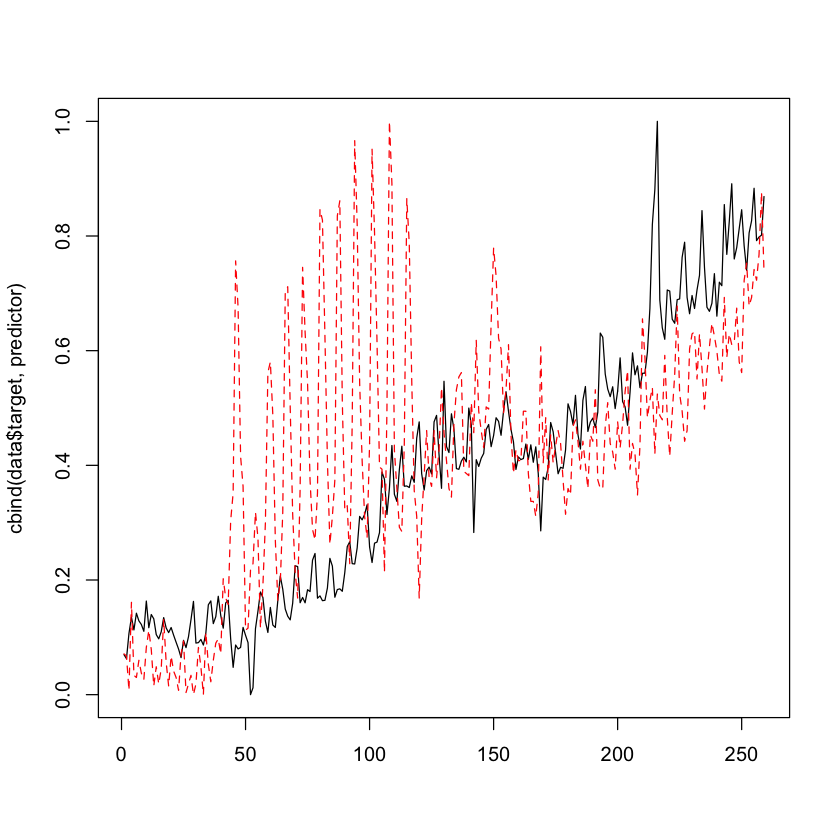

In [69]:
predictor <- data$may_be_not_impacted_12
matplot(cbind(data$target, predictor), type = "l")

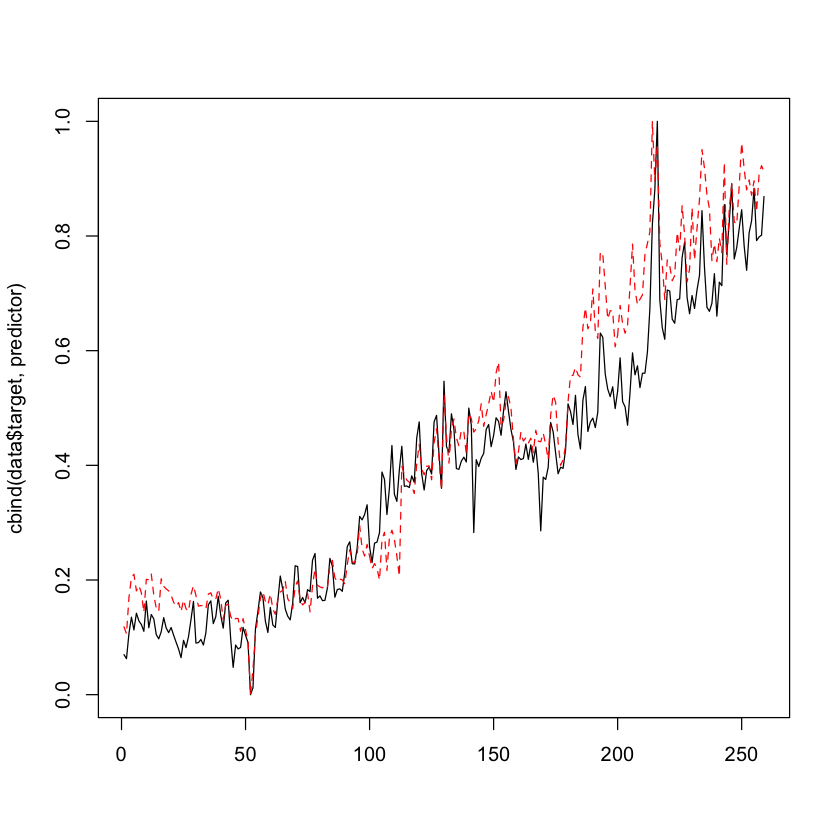

In [128]:
predictor <- data$should_be_impacted_13
matplot(cbind(data$target, predictor), type = "l")

Warning message:
“Removed 259 rows containing missing values (geom_path).”Warning message:
“Removed 518 rows containing missing values (geom_path).”

Posterior inference {CausalImpact}

                         Average           Cumulative      
Actual                   0.58              68.83           
Prediction (s.d.)        0.65 (0.025)      76.17 (2.902)   
95% CI                   [0.6, 0.69]       [70.5, 81.89]   
                                                           
Absolute effect (s.d.)   -0.062 (0.025)    -7.335 (2.902)  
95% CI                   [-0.11, -0.014]   [-13.06, -1.709]
                                                           
Relative effect (s.d.)   -9.6% (3.8%)      -9.6% (3.8%)    
95% CI                   [-17%, -2.2%]     [-17%, -2.2%]   

Posterior tail-area probability p:   0.0098
Posterior prob. of a causal effect:  99.01961%

For more details, type: summary(impact, "report")



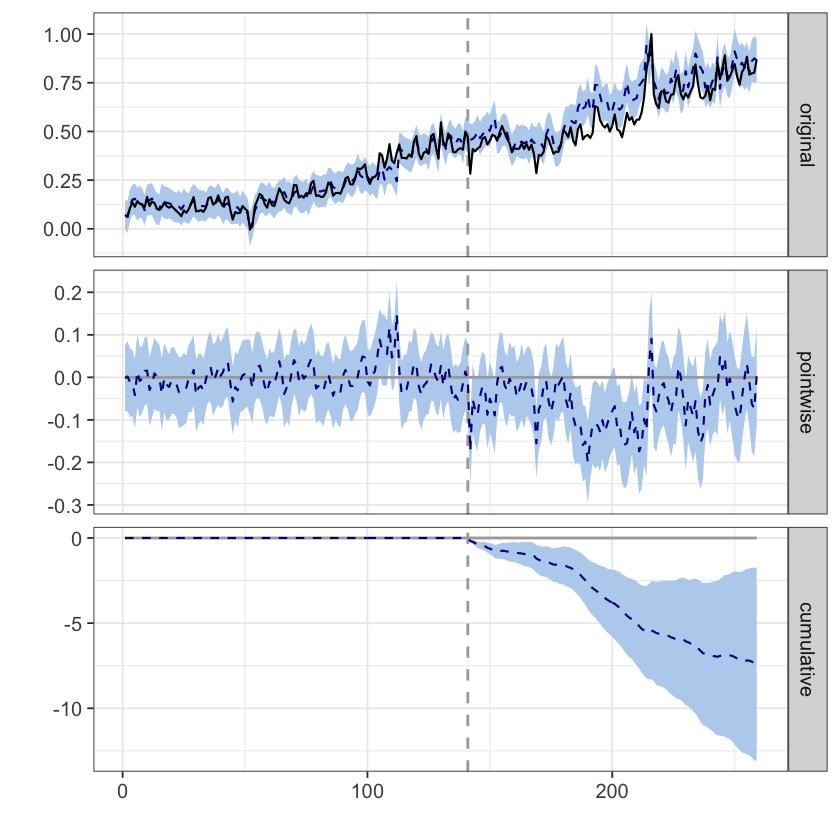

In [130]:
pre.period <- c(1, 141) # 12 марта - 31 июля
post.period <- c(142, 259) # 1 июня - 31 июля

# pre.period <- c(1, 80) # 12 марта - 31 мая
# post.period <- c(81, 141) # 1 июня - 31 июля

set.seed(0)
target <- data$target
impact <- CausalImpact(cbind(target, predictor), pre.period, post.period)
plot(impact)
summary(impact)